In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import MeanShift, estimate_bandwidth

from collections import Counter
from itertools import groupby
import re, os, sys, glob, shutil

import tqdm
%config Completer.use_jedi = False

pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
pd.set_option('display.max_colwidth', 50)  # or 199


import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [2]:
intub_codes = pd.read_csv('intub_codes.csv')
intub_codes.head()

,itemid,diagnoses_icd_code,diagnosis_icd_version,procedures_icd_code,procedures_icd_version
0,228643,4957,9.0,9655,9.0
1,226191,99731,9.0,311,9.0
2,225593,J9585,10.0,0BW18FZ,10.0
3,225304,J95851,10.0,0BW17FZ,10.0
4,228068,J95859,10.0,0BW14FZ,10.0


### CHARTEVENTS

In [4]:
def preprocess(data) :
    sample = data[data['itemid'].isin(intub_codes['itemid'].tolist())]
    return sample


chunk_size = 10**5
list_of_samples = []
list_of_outcome_samples = []
for cnt, chunk in enumerate(pd.read_csv('../1.0/icu/chartevents.csv', 
                                        chunksize=chunk_size, low_memory=False)) :
    sample = preprocess(chunk)
    list_of_samples.append(sample)

sample_chart = pd.concat(list_of_samples)

### PROCEDUREEVENTS

In [5]:
procedureevents = pd.read_csv('../1.0/icu/procedureevents.csv')
sample_procedure = procedureevents[procedureevents['itemid']\
                                       .isin(intub_codes['itemid'].tolist())]

In [6]:
d_item_id = pd.read_csv('../1.0/icu/d_items.csv')

sample_chart = pd.merge(sample_chart, d_item_id[['itemid', 'label']], 
                        on='itemid', how='left')
sample_procedure = pd.merge(sample_procedure, d_item_id[['itemid', 'label']], 
                        on='itemid', how='left')
sample_chart.shape, sample_procedure.shape

((1290682, 11), (41304, 27))

###  ICUSTAY

In [7]:
icustays = pd.read_csv('../1.0/icu/icustays.csv')
icustays['intime'] = pd.to_datetime(icustays['intime'])
icustays['outtime'] = pd.to_datetime(icustays['outtime'])

sample_chart = pd.merge(sample_chart, icustays, 
                        on=['subject_id', 'hadm_id', 'stay_id'], how='left')
sample_procedure = pd.merge(sample_procedure, icustays,
                            on=['subject_id', 'hadm_id', 'stay_id'], how='left')

sample_chart['charttime'] = pd.to_datetime(sample_chart['charttime'])
sample_procedure['starttime'] = pd.to_datetime(sample_procedure['starttime'])
sample_chart['lapse_hours'] = sample_chart.\
                                  apply(lambda x: (x['charttime']-x['intime'])/\
                                                   pd.Timedelta(1,'H'), axis=1)
sample_procedure['lapse_hours'] = sample_procedure.\
                                       apply(lambda x: (x['starttime']-x['intime'])/\
                                                        pd.Timedelta(1,'H'), axis=1)

#### ADMISSION 

In [8]:
admissions = pd.read_csv('../1.0/core/admissions.csv.gz', compression='gzip')
admissions['deathtime'] = pd.to_datetime(admissions['deathtime'])

### Intubation 유무 판단 알고리즘
- Intubation, Invasive ventilation (direct evidence)가 나오면 무조건 include되며, intubation 시각은 직접정황의 시각으로 
- 24시간 이내 간접정황이 5개 이상 나오면 include 된것으로 판단하고 intubation 시각은 제일 처음 나오는 indirect evidence의 시각으로 

In [14]:
direct_signs = [224385, 225792]
indirect_signs = [223849, 229314, 223848]

T_cutoff = 0 # hours
endureT = 24 # hours

In [15]:
def intub_label_plt(intub, path, day_died, intub_moment_index=None) :
    
    jet = plt.cm.jet
    
    fig, ax = plt.subplots(1, 1, figsize=(18, 6))
    intub_label_color_dict = dict(zip(intub['label'].unique().tolist(), 
                                      jet(np.linspace(0, 1, intub['label'].unique().shape[0]))))

    icu_in_instance = intub.loc[0, 'intime']
    icu_out_instance = intub.loc[0, 'outtime']
    for j, row in intub.iterrows() :
        if row['itemid'] in direct_signs :
            ax.axvline(x=row['intubtime'], linewidth=3, label=row['label'],
                       color=intub_label_color_dict[row['label']])
        else :
            ax.axvline(x=row['intubtime'], linewidth=1, label=row['label'],
                       color=intub_label_color_dict[row['label']])

    ax.axvline(x=icu_in_instance, linewidth=2, linestyle='--', color='k', label='icu in')
    ax.axvline(x=icu_out_instance, linewidth=2, linestyle='--', color='k', label='icu out')
    
    dur_events = (intub['intubtime'].max() - intub['intime'].min()) / pd.Timedelta(1, 'D')
    if dur_events <= 0 :
        dur_events = 30
    
    if not pd.isnull(day_died) :
        ax.axvline(x=day_died, linewidth=3.5, linestyle='-.', color='gray', label='Death')
        
    if intub_moment_index != None:
        ax.axvspan(intub.iloc[intub_moment_index]['intubtime'], intub['intubtime'].max(), 
                   facecolor='orange', label='Intub. events era', alpha=0.25)
        
        if not pd.isnull(day_died) :
            ax.set_xlim([icu_in_instance - pd.Timedelta(2, 'D'), 
                         max(day_died + pd.Timedelta(2, 'D'), icu_out_instance + pd.Timedelta(2, 'D'), 
                             intub.iloc[intub_moment_index]['intubtime'] + pd.Timedelta(31, 'D'))])
        else :
            ax.set_xlim([icu_in_instance - pd.Timedelta(2, 'D'), 
                         max(icu_out_instance + pd.Timedelta(2, 'D'), 
                             intub.iloc[intub_moment_index]['intubtime'] + pd.Timedelta(31, 'D'))])
    else :
        ax.set_xlim([icu_in_instance - pd.Timedelta(1, 'D'), 
                     icu_out_instance + pd.Timedelta(1, 'D')])
    ax.tick_params(axis='both', which='major', labelsize=12)
    # 범례 중복된 라벨 제거
    handles, labels = ax.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    ax.legend(handle_list, label_list, fontsize=12)
    if intub_moment_index != None:
        ax.set_title("Intubation events of stay_id = {}, intubation in {} hours at ICU"\
                     .format(intub.loc[0, 'stay_id'], 
                             np.round(intub.iloc[intub_moment_index]['lapse_hours'], 1)), 
                     fontsize=13)
    else :
        ax.set_title("Intubation events of stay_id = {}".format(intub.loc[0, 'stay_id']), 
                     fontsize=13)
      
    

#     plt.show()
    fig.set_facecolor("white")    
    plt.savefig(os.path.join(path, str(intub.loc[0, 'stay_id'])))
    plt.close()
    plt.clf()
                
                
    
person_ids = pd.concat([sample_chart[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates(), 
                        sample_procedure[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates()], 
                        ignore_index=True).drop_duplicates()
path_leaving_out = 'figures_leaving_out_zero'
os.makedirs(path_leaving_out, exist_ok=True)
path_pass = 'figures_pass_zero'
os.makedirs(path_pass, exist_ok=True)
num_samples_explicit_intubation = 0
incl_events = pd.DataFrame()
incl_persons = pd.DataFrame(columns=['subject_id', 'hadm_id', 'stay_id'])



for i, row in person_ids.iterrows() :
    _cdata = sample_chart[(sample_chart['subject_id']==row['subject_id'])&\
                          (sample_chart['hadm_id']==row['hadm_id']) &\
                          (sample_chart['stay_id']==row['stay_id'])]
    _pdata = sample_procedure[(sample_procedure['subject_id']==row['subject_id'])&\
                              (sample_procedure['hadm_id']==row['hadm_id'])&\
                              (sample_procedure['stay_id']==row['stay_id'])]

    intub = pd.concat([_cdata[['subject_id', 'hadm_id', 'stay_id',
                               'charttime', 'value', 'valueuom', 'itemid', 
                               'first_careunit', 'last_careunit', 'label',
                               'intime', 'outtime', 'los', 'lapse_hours']]\
                           .rename(columns={'charttime':'intubtime'}), 
                       _pdata[['subject_id', 'hadm_id', 'stay_id',
                               'starttime', 'value', 'valueuom', 'itemid',
                               'first_careunit', 'last_careunit', 'label',
                               'intime', 'outtime', 'los', 'lapse_hours']]\
                           .rename(columns={'starttime':'intubtime'})], 
                       ignore_index=True).sort_values(by='lapse_hours')\
                                             .reset_index().drop(columns=['index'])
    intub['do_intub'] = 0
    day_died = admissions[(admissions['subject_id']==row['subject_id']) &\
                              (admissions['hadm_id']==row['hadm_id'])].iloc[0]['deathtime']
    
    
    inclusion = 0
    # direct signs 중 가장 먼저 나오는 시각이 intubation time
    if intub[intub['itemid'].isin(direct_signs)].shape[0] > 0 :
        inclusion = 1
        intub_moment = intub[intub['itemid'].isin(direct_signs)]\
                           .sort_values(by='intubtime').iloc[0]['lapse_hours']
        intub_index = intub[intub['itemid'].isin(direct_signs)]\
                           .sort_values(by='intubtime').index[0]
        
    # indirect signs의 경우 5번의 정황이 24시간이내 있을 경우 5번 중 처음 event시각이 intubation time
    else :
        if intub[intub['itemid'].isin(indirect_signs)].shape[0] >= 5 :
            fifth = intub[intub['itemid'].isin(indirect_signs)].iloc[4]['lapse_hours']
            first = intub[intub['itemid'].isin(indirect_signs)].iloc[0]['lapse_hours']
            if fifth-first < endureT :
                inclusion = 1
                intub_moment = intub.iloc[0]['lapse_hours']
                intub_index = 0

    # 위의 두 조건을 만족하며, intubation이 icu입실 24시간 이후에 나타날 때 sample에 포함
    if inclusion == 1 and intub_moment >= T_cutoff : 
        intub.loc[intub_index, 'do_intub'] = 1
        # 샘플 정보 저장
        incl_persons.loc[len(incl_persons)] = [row['subject_id'], row['hadm_id'], 
                                               row['stay_id']]
        if incl_events.empty : 
            incl_events = intub.copy()
        else :
            incl_events = pd.concat([incl_events, intub], ignore_index=True)

        # inclusion sample 검증용 그림 작성  
        intub_label_plt(intub=intub, path=path_pass, day_died=day_died, 
                        intub_moment_index=intub_index)
        
    # 샘플에서 탈락된 경우 검증용 그림 작성
    else :
        intub_label_plt(intub=intub, path=path_leaving_out, day_died=day_died)

<Figure size 432x288 with 0 Axes>

In [116]:
intub_duration = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'stay_id', 'intub_duration'])
for i, row in incl_events[['subject_id', 'hadm_id', 'stay_id']].drop_duplicates().iterrows() :
    _patient = incl_events[(incl_events['subject_id']==row['subject_id'])&\
                          (incl_events['hadm_id']==row['hadm_id'])&\
                          (incl_events['stay_id']==row['stay_id'])]
    _intub_duration = (_patient.sort_values(by='intubtime', ascending=False).iloc[0]['intubtime'] - \
                       _patient[(_patient['do_intub']==1)].iloc[0]['intubtime']) / pd.Timedelta(1, unit='d')
    intub_duration.loc[len(intub_duration)] = [row['subject_id'], row['hadm_id'], row['stay_id'], _intub_duration]

In [117]:
intubs = incl_events[incl_events['do_intub']==1]
intubs.shape

(28065, 15)

In [118]:
intubs = incl_events[incl_events['do_intub']==1]
intubs = pd.merge(intubs, intub_duration, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
print(intubs['subject_id'].nunique())
intubs.head()

24379


,subject_id,hadm_id,stay_id,intubtime,value,valueuom,itemid,first_careunit,last_careunit,label,intime,outtime,los,lapse_hours,do_intub,intub_duration
0,14411859,24976204,38018615,2162-12-29 15:00:00,135267,min,225792,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),Invasive Ventilation,2162-12-28 22:59:00,2163-04-09 16:24:47,101.726238,16.016667,1,100.541667
1,10003700,28623837,30600691,2165-04-24 05:47:00,206,min,225792,Trauma SICU (TSICU),Trauma SICU (TSICU),Invasive Ventilation,2165-04-24 05:43:00,2165-04-24 09:13:20,0.146065,0.066667,1,0.092361
2,10004720,22081550,35009126,2186-11-12 20:29:00,6811,min,225792,Surgical Intensive Care Unit (SICU),Medical Intensive Care Unit (MICU),Invasive Ventilation,2186-11-12 19:55:00,2186-11-17 21:15:55,5.056192,0.566667,1,4.646528
3,10005348,25239799,34629895,2130-10-27 16:45:00,710,min,225792,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),Invasive Ventilation,2130-10-27 12:06:00,2130-10-29 12:05:02,1.999329,4.650000,1,0.510417
4,10009035,28324362,38507547,2161-04-27 11:55:00,100,min,225792,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),Invasive Ventilation,2161-04-27 10:38:12,2161-04-28 15:06:17,1.186169,1.280000,1,0.045139


### Unique id =  (가장 이른 시점에 intubation을 시행한) subject_id

In [119]:
intubs = intubs.sort_values(by=['subject_id', 'intubtime']).drop_duplicates(subset='subject_id')

### AGE cutoff

(65743, 2)


,hadm_id,age
0,26181656,18
1,24711384,18
2,26648805,18
3,25077309,18
4,25701109,90


<AxesSubplot:xlabel='age', ylabel='Count'>

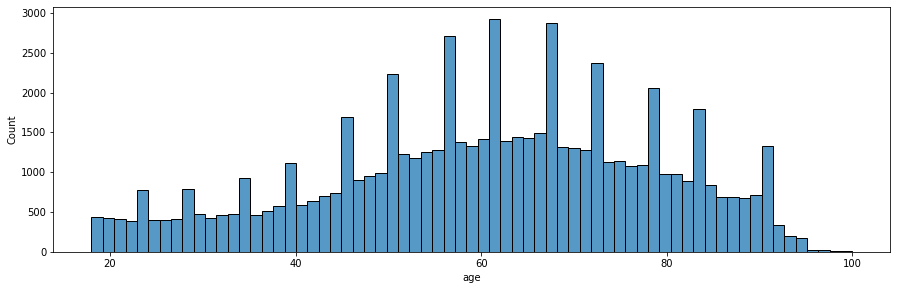

In [120]:
ids = pd.read_csv('result_age_18_100.csv')
ids.drop(columns=['Unnamed: 0'], inplace=True)
print(ids.shape)
display(ids.head())
fig, ax = plt.subplots(1, 1, figsize=(15, 4.5))
sns.histplot(data=ids, x='age', ax=ax)

In [121]:
print("Patients with the evidence for mechanical ventilation (n={})".format(intubs['subject_id'].nunique()))
age18to100 = intubs[intubs['hadm_id'].isin(ids['hadm_id'].unique().tolist())]['subject_id'].nunique()
print("age < 18 or > 100 years (n={})".format(intubs['subject_id'].nunique()-age18to100))
intubs_age = intubs[intubs['hadm_id'].isin(ids['hadm_id'].unique().tolist())]
print('After applied age criterion (n={})'.format(intubs_age['subject_id'].nunique()))

Patients with the evidence for mechanical ventilation (n=24379)
age < 18 or > 100 years (n=70)
After applied age criterion (n=24309)


In [122]:
intubs_age['age'] = intubs_age['hadm_id'].apply(lambda x: ids.loc[ids['hadm_id']==int(x), 'age'].iloc[0])

### Was there a record of previous tracheostomy included samples?

In [123]:
# Tracheostomy 시행한 정황증거 코드를 식별한다. 
tracheo_codes = pd.read_csv('trache_icd.csv')
tracheo_codes

,itemid,icd_code,icd_version,long_title
0,225448.0,9655,9,Tracheostomy toilette
1,226237.0,311,9,Temporary tracheostomy
2,NaN,0BW18FZ,10,"Revision of Tracheostomy Device in Trachea, Vi..."
3,NaN,0BW17FZ,10,"Revision of Tracheostomy Device in Trachea, Vi..."
4,NaN,0BW14FZ,10,"Revision of Tracheostomy Device in Trachea, Pe..."
5,NaN,0BW13FZ,10,"Revision of Tracheostomy Device in Trachea, Pe..."
6,NaN,0BW10FZ,10,"Revision of Tracheostomy Device in Trachea, Op..."
7,NaN,0BW1XFZ,10,"Revision of Tracheostomy Device in Trachea, Ex..."
8,NaN,3174,9,Revision of tracheostomy
9,NaN,9723,9,Replacement of tracheostomy tube


In [124]:
def preprocess_tracheo(data) :
    sample = data[data['itemid'].isin(tracheo_codes['itemid'].dropna().tolist())]
    return sample


chunk_size = 10**5
list_of_tracheos = []
for cnt, chunk in enumerate(pd.read_csv('../1.0/icu/chartevents.csv', 
                                        chunksize=chunk_size, low_memory=False)) :
    _tracheos = preprocess_tracheo(chunk)
    list_of_tracheos.append(_tracheos)

tracheos_events = pd.concat(list_of_tracheos)

In [125]:
tracheos_events

,subject_id,hadm_id,stay_id,charttime,storetime,itemid,value,valuenum,valueuom,warning


In [126]:
tracheo_procedures = procedureevents[procedureevents['itemid']\
                                    .isin(tracheo_codes['itemid'].dropna().tolist())]
tracheo_procedures['starttime'] = pd.to_datetime(tracheo_procedures['starttime'])
tracheo_procedures

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,value,valueuom,location,locationcategory,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,comments_date,originalamount,originalrate
154,19004463,24357541,39101627,2177-02-04 17:37:00,2177-02-04 17:38:00,2177-02-04 17:37:00,225448,1.0,None,NaN,NaN,2818071,2818071,Procedures,NaN,Task,76.1,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
595,16539032,25235591,39072931,2138-01-20 08:51:00,2138-01-20 08:52:00,2138-01-20 08:51:00,225448,1.0,None,NaN,NaN,7001545,7001545,Procedures,NaN,Task,53.4,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
1388,18076679,23717746,35979735,2184-04-16 17:00:00,2184-04-16 17:01:00,2184-04-17 16:45:00,226237,1.0,None,NaN,NaN,5799118,5799118,Procedures,NaN,Task,97.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
1502,12662773,20446083,32238735,2145-05-28 10:00:00,2145-05-28 10:01:00,2145-05-28 11:40:00,225448,1.0,None,NaN,NaN,1305646,1305646,Procedures,NaN,Task,91.2,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
2328,19193891,25790502,33193862,2145-08-28 16:05:00,2145-08-28 16:06:00,2145-08-28 16:25:00,225448,1.0,None,NaN,NaN,788920,788920,Procedures,NaN,Task,101.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
721644,14071688,23333715,35395023,2160-03-27 13:55:00,2160-03-27 13:56:00,2160-03-27 13:55:00,225448,1.0,None,NaN,NaN,7335369,7335369,Procedures,NaN,Task,64.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
721646,14071688,23333715,35395023,2160-03-29 14:00:00,2160-03-29 14:01:00,2160-03-29 14:00:00,225448,1.0,None,NaN,NaN,8026057,8026057,Procedures,NaN,Task,64.0,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
727540,10308187,25011041,31803488,2137-06-19 17:15:00,2137-06-19 17:16:00,2137-06-19 17:47:00,225448,1.0,None,NaN,NaN,4076496,4076496,Procedures,NaN,Task,111.9,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0
729984,13372200,26628430,31196251,2121-09-06 10:39:00,2121-09-06 10:40:00,2121-09-06 10:39:00,225448,1.0,None,NaN,NaN,2101988,2101988,Procedures,NaN,Task,63.5,NaN,NaN,0,0,0,FinishedRunning,NaN,1.0,0


In [127]:
inputevents = pd.read_csv('../1.0/icu/inputevents.csv')
tracheo_inputs = inputevents[inputevents['itemid'].isin(tracheo_codes['itemid'].dropna().tolist())]
tracheo_inputs

,subject_id,hadm_id,stay_id,starttime,endtime,storetime,itemid,amount,amountuom,rate,rateuom,orderid,linkorderid,ordercategoryname,secondaryordercategoryname,ordercomponenttypedescription,ordercategorydescription,patientweight,totalamount,totalamountuom,isopenbag,continueinnextdept,cancelreason,statusdescription,originalamount,originalrate


In [128]:
procedures_hosp = pd.read_csv('../1.0/hosp/procedures_icd.csv.gz')
tracheo_procedures_hosp = procedures_hosp[procedures_hosp['icd_code']\
                                          .isin(tracheo_codes['icd_code'].dropna().tolist())]
tracheo_procedures_hosp['chartdate'] = pd.to_datetime(tracheo_procedures_hosp['chartdate'])
tracheo_procedures_hosp

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
82,12615486,22971263,2,2124-08-20,311,9
612,14697313,28441017,1,2180-09-12,3174,9
701,17431467,26718911,1,2135-02-17,311,9
1208,19386801,26509628,2,2161-09-26,311,9
1418,19004463,24357541,1,2177-02-04,311,9
...,...,...,...,...,...,...
778871,13610225,29859439,2,2134-07-27,0B113F4,10
778985,17340901,23121925,4,2188-03-21,0B21XFZ,10
779050,16307213,23083430,17,2172-11-24,0B21XFZ,10
779090,18252838,22671212,12,2131-12-06,0B21XFZ,10


#### 환자마다 intubation 이전 기간에 Tracheostomy를 한 정황이 있는가?

In [129]:
tracheo_records = pd.DataFrame(columns = ['subject_id', 'hadm_id', 'stay_id', 'intubtime', 
                                          'tracheotime', 'itemid', 'icd_code'])
for i, row in intubs_age.iterrows() :
    icu_tracheo_event = tracheo_procedures[(tracheo_procedures['subject_id']==row['subject_id'])&\
                                           (tracheo_procedures['hadm_id']==row['hadm_id'])&\
                                           (tracheo_procedures['stay_id']==row['stay_id'])&\
                                           (tracheo_procedures['starttime']<=row['intubtime'])]
    hosp_tracheo_event = tracheo_procedures_hosp[(tracheo_procedures_hosp['subject_id']==row['subject_id'])&\
                                                (tracheo_procedures_hosp['hadm_id']==row['hadm_id'])&\
                                                (tracheo_procedures_hosp['chartdate']<=row['intubtime'])]
    if icu_tracheo_event.shape[0] > 0 : 
        tracheo_records.loc[len(tracheo_records)] = [row['subject_id'], row['hadm_id'], row['stay_id'], 
                                                    row['intubtime'], icu_tracheo_event['starttime'].iloc[0], 
                                                    icu_tracheo_event['itemid'].iloc[0], None]
    if hosp_tracheo_event.shape[0] > 0 :
        tracheo_records.loc[len(tracheo_records)] = [row['subject_id'], row['hadm_id'], None, row['intubtime'],
                                                    hosp_tracheo_event['chartdate'].iloc[0], None,
                                                    hosp_tracheo_event['icd_code'].iloc[0]]

In [130]:
tracheo_records.sort_values(by=['tracheotime']).drop_duplicates(subset='subject_id')

,subject_id,hadm_id,stay_id,intubtime,tracheotime,itemid,icd_code
83,14924112,24928700,None,2110-11-03 22:26:00,2110-11-03,None,0B110F4
107,16816440,25634666,None,2111-02-16 12:03:00,2111-02-16,None,311
19,11062235,22950722,None,2112-05-22 23:45:00,2112-05-22,None,0B113F4
16,10915432,29745343,None,2113-08-14 17:00:00,2113-08-14,None,311
18,11014450,20727239,None,2113-12-12 20:25:00,2113-12-12,None,0B110F4
...,...,...,...,...,...,...,...
132,18264212,29561222,None,2190-05-15 07:11:00,2190-05-15,None,3129
21,11144816,22276209,None,2194-02-14 10:45:00,2194-02-14,None,0B110F4
8,10600660,25575769,None,2196-04-21 18:45:00,2196-04-21,None,311
126,18096934,24262573,None,2197-08-25 01:15:00,2197-08-24,None,0B110F4


In [131]:
print('(n={}) already had a tracheostomy'.format(tracheo_records['subject_id'].nunique()))
intubs_age_tracheo = intubs_age[~intubs_age['subject_id'].isin(tracheo_records['subject_id'].unique().tolist())]
print('After applied tracheostomy criterion (n={})'.format(intubs_age_tracheo['subject_id'].nunique()))

(n=152) already had a tracheostomy
After applied tracheostomy criterion (n=24157)


When the prolonged MV is equal to or greater than 14 days of intubation: N(prolonged MV) = 1142, N(~prolonged MV) = 23015
When the prolonged MV is equal to or greater than 21 days of intubation: N(prolonged MV) = 501, N(~prolonged MV) = 23656


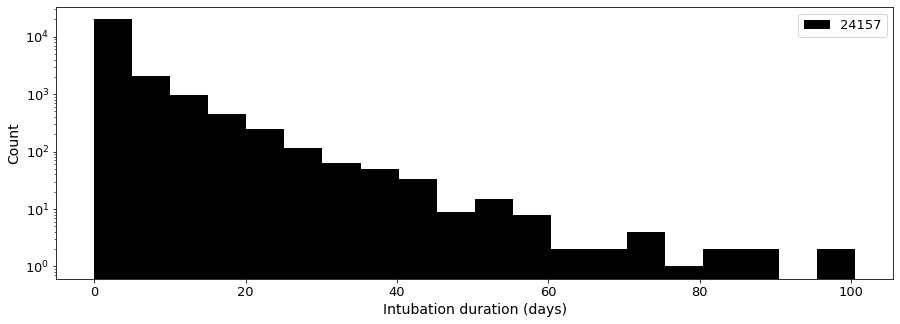

In [132]:
print('When the prolonged MV is equal to or greater than 14 days of intubation: ', end='')
print('N(prolonged MV) = {}, N(~prolonged MV) = {}'\
      .format(intubs_age_tracheo[intubs_age_tracheo['intub_duration']>=14].shape[0],
              intubs_age_tracheo[intubs_age_tracheo['intub_duration']<14].shape[0]))
print('When the prolonged MV is equal to or greater than 21 days of intubation: ', end='')
print('N(prolonged MV) = {}, N(~prolonged MV) = {}'\
      .format(intubs_age_tracheo[intubs_age_tracheo['intub_duration']>=21].shape[0], 
              intubs_age_tracheo[intubs_age_tracheo['intub_duration']<21].shape[0]))

fig = plt.figure(figsize = (15,5))
ax = fig.gca()
ax.hist(intubs_age_tracheo['intub_duration'], bins=20, log=True, color='k', label=str(intubs_age_tracheo.shape[0]))
ax.tick_params(axis='both', which='major', labelsize=13)
ax.set_xlabel('Intubation duration (days)', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.legend(fontsize=13)

### Mortality data merging

In [133]:
total_mortality = pd.merge(intubs_age_tracheo, admissions, on=['subject_id', 'hadm_id'], how='left')
print(total_mortality.shape)

total_mortality['deathtime'] = pd.to_datetime(total_mortality['deathtime'])
total_mortality['intub_death_interval_days'] = \
    total_mortality.apply(lambda x: (x['deathtime']-x['intubtime'])/pd.Timedelta(1, 'D') \
                                    if x['hospital_expire_flag']==1 else None, axis=1)

total_mortality['mortality14'] = total_mortality['intub_death_interval_days']\
                                  .apply(lambda x: 1 if x > 0 and x < 14 else 0)
print(total_mortality.shape)
total_mortality['mortality14'].value_counts()

total_mortality_yes = total_mortality[total_mortality['mortality14']==1].sort_values(by='deathtime')\
                        .drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id'])
print(total_mortality_yes.shape)
total_mortality_no = total_mortality[total_mortality['mortality14']==0].sort_values(by='deathtime')\
                      .drop_duplicates(subset=['subject_id', 'hadm_id', 'stay_id'])
print(total_mortality_no.shape)
# total0 = total[total['tracheostomy_yes']==0]
total_mortality = pd.concat([total_mortality_yes, total_mortality_no], ignore_index=True)
total_mortality.shape

(24157, 30)
(24157, 32)
(3417, 32)
(20740, 32)


(24157, 32)

In [134]:
total_mortality['OUTCLASS3'] = total_mortality\
                                   .apply(lambda x: 1 if x['intub_duration']>=14 \
                                                      else(2 if x['mortality14']==1 else 0), axis=1)
display(total_mortality['OUTCLASS3'].value_counts())
total_mortality['OUTCLASS2'] = total_mortality['OUTCLASS3'].apply(lambda x: 0 if x==0 else 1)
display(total_mortality['OUTCLASS2'].value_counts())

0    19600
2     3415
1     1142
Name: OUTCLASS3, dtype: int64

0    19600
1     4557
Name: OUTCLASS2, dtype: int64

In [135]:
total_mortality.to_csv('samples_mimic4_planB.csv', index=False)

<AxesSubplot:xlabel='age', ylabel='Count'>

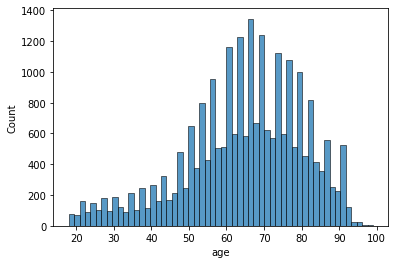

In [136]:
sns.histplot(data=total_mortality, x='age')